### Fluorescence Segmentation

Here, I compile the fluorescence segmentation into a single class. Does not require I/O based memory management, so it should not require seperate classes for the interactive and production modules.

In [7]:
import numpy as np
import skimage as sk
import h5py
from matplotlib import pyplot as plt
import skimage.filters
from skimage import measure,feature,segmentation,future,util
from skimage.filters import threshold_otsu, threshold_niblack, rank
from skimage.morphology import disk
from scipy import ndimage

In [8]:
import trenchripper as tr

In [9]:
class fluo_segmentation:
    def __init__(self,input_file_prefix,output_path,all_channels,smooth_sigma=0.75,wrap_pad=3,hess_pad=4,min_obj_size=30,\
                 local_otsu_r=15,threshold_range=20,threshold_step=5,convex_threshold=0.8):
        
        
        self.input_file_prefix = input_file_prefix
        self.output_path = output_path
        self.all_channels = all_channels
        
        self.smooth_sigma = smooth_sigma
        self.wrap_pad = wrap_pad
        self.hess_pad = hess_pad
        self.min_obj_size = min_obj_size
        self.local_otsu_r = local_otsu_r
        self.threshold_range = threshold_range
        self.threshold_step = threshold_step
        self.convex_threshold = convex_threshold
    
    def to_8bit(self,img_arr):
        max_val = np.max(img_arr)
        min_val = np.min(img_arr)
        norm_array = (img_arr-min_val)/(max_val-min_val)
        norm_byte_array = sk.img_as_ubyte(norm_array)
        return norm_byte_array
    
    def preprocess_img(self,img_arr,sigma=1.):
        img_smooth = self.to_8bit(sk.filters.gaussian(img_arr,sigma=sigma,preserve_range=True,mode='reflect'))
        return img_smooth
    
    def hessian_contrast_enc(self,img_arr,edge_padding=0):
        img_arr = np.pad(img_arr, edge_padding, 'reflect')
        hessian = sk.feature.hessian_matrix(img_arr,order="rc")
        eigvals = sk.feature.hessian_matrix_eigvals(hessian)
        min_eigvals = np.min(eigvals,axis=0)
        if edge_padding>0:
            min_eigvals = min_eigvals[edge_padding:-edge_padding,edge_padding:-edge_padding]
        return min_eigvals
    
    def find_mask(self,cell_local_mask,min_eigvals,edge_threshold,min_size=30):
        edge_mask = min_eigvals>edge_threshold
        edge_mask = sk.morphology.binary_closing(edge_mask)
        composite_mask = cell_local_mask*edge_mask
        composite_mask = sk.morphology.remove_small_objects(composite_mask,min_size=min_size)
        composite_mask = sk.morphology.remove_small_holes(composite_mask)
        return composite_mask
    
    def compute_convexity(self,curr_obj):    
        area = np.sum(curr_obj)
        convex_hull = sk.morphology.convex_hull_image(curr_obj)
        convex_hull_area = np.sum(convex_hull)
        convexity = area/convex_hull_area
        return convexity
    
    def get_object_coords(self,obj_thresh,padding=1):    
        x_dim_max = np.max(obj_thresh,axis=0)
        x_indices = np.where(x_dim_max)[0]
        x_min = max(np.min(x_indices)-padding,0)
        x_max = min(np.max(x_indices)+padding+1,obj_thresh.shape[1])

        y_dim_max = np.max(obj_thresh,axis=1)
        y_indices = np.where(y_dim_max)[0]
        y_min = max(np.min(y_indices)-padding,0)
        y_max = min(np.max(y_indices)+padding+1,obj_thresh.shape[0])

        return x_min,x_max,y_min,y_max
    
    def crop_object(self,conn_comp,obj_idx,padding=1):
        obj_thresh = (conn_comp==obj_idx)
        x_min,x_max,y_min,y_max = self.get_object_coords(obj_thresh,padding=padding)
        curr_obj = obj_thresh[y_min:y_max,x_min:x_max]
        return curr_obj

    def get_image_weights(self,conn_comp,padding=1):
        objects = np.unique(conn_comp)[1:]
        weights = []
        for obj_idx in objects:
            curr_obj = self.crop_object(conn_comp,obj_idx,padding=padding)
            weight = self.compute_convexity(curr_obj)
            weights.append(weight)
        return np.array(weights)
    
    def make_weight_arr(self,conn_comp,weights):
        weight_arr = np.zeros(conn_comp.shape)
        for i,obj_weight in enumerate(weights):
            obj_idx = i+1
            obj_mask = (conn_comp==obj_idx)
            weight_arr[obj_mask] = obj_weight
        return weight_arr

    def get_mid_threshold_arr(self,wrap_eig,padding=3):
        edge_threshold_kymo = []
        for t in range(wrap_eig.shape[-1]):
            edge_threshold = sk.filters.threshold_otsu(wrap_eig[:,:,t])
            edge_thr_arr = edge_threshold*np.ones(wrap_eig[:,:,t].shape,dtype='uint8')
            edge_threshold_kymo.append(edge_thr_arr)
        edge_threshold_kymo = np.array(edge_threshold_kymo)
        edge_threshold_kymo = np.moveaxis(edge_threshold_kymo,(0,1,2),(2,0,1))

        edge_thr_kymo = tr.utils.kymo_handle()
        edge_thr_kymo.import_wrap(edge_threshold_kymo,scale=False)
        mid_threshold_arr = edge_thr_kymo.return_unwrap(padding=padding)
        return mid_threshold_arr

    def get_convex_scores(self,cell_local_mask,min_eigvals,mid_threshold_arr,threshold_range=20,threshold_step=5):
        edge_thresholds = [mid_threshold_arr+i for i in range(-threshold_range,threshold_range,threshold_step)]
        weight_arrs = []
        for edge_threshold in edge_thresholds:
            composite_mask = self.find_mask(cell_local_mask,min_eigvals,edge_threshold,min_size=30)
            conn_comp = sk.measure.label(composite_mask,neighbors=4,connectivity=2)
            weights = self.get_image_weights(conn_comp)
            weight_arr = self.make_weight_arr(conn_comp,weights)
            weight_arrs.append(weight_arr)
        weight_arrs = np.array(weight_arrs)
        max_merged = np.max(weight_arrs,axis=0)
        return max_merged 
    
    def segment(self,img_arr):
        input_kymo = tr.utils.kymo_handle()
        input_kymo.import_wrap(img_arr,scale=True,scale_perc=95)
        t_tot = input_kymo.kymo_arr.shape[-1]

        working_img = self.preprocess_img(input_kymo.return_unwrap(padding=self.wrap_pad),sigma=self.smooth_sigma)
        del input_kymo

        inverted = sk.util.invert(working_img)
        min_eigvals = self.to_8bit(self.hessian_contrast_enc(inverted,self.hess_pad))
        del inverted

        otsu_selem = disk(self.local_otsu_r)
        local_otsu = rank.otsu(working_img, otsu_selem)
        cell_local_mask = working_img>local_otsu
        del working_img

        cell_region_threshold = sk.filters.threshold_otsu(local_otsu)
        cell_region_mask = local_otsu>cell_region_threshold
        del local_otsu
        cell_local_mask=cell_local_mask*cell_region_mask
        del cell_region_mask

        eig_kymo = tr.utils.kymo_handle()
        eig_kymo.import_unwrap(min_eigvals,t_tot,padding=self.wrap_pad)
        wrap_eig = eig_kymo.return_wrap()
        mid_threshold_arr = self.get_mid_threshold_arr(wrap_eig,padding=self.wrap_pad)
        del wrap_eig

        convex_scores = self.get_convex_scores(cell_local_mask,min_eigvals,mid_threshold_arr,\
                                          threshold_range=self.threshold_range,threshold_step=self.threshold_step)
        del cell_local_mask
        del min_eigvals
        del mid_threshold_arr

        final_mask = convex_scores>self.convex_threshold

        output_kymo = tr.utils.kymo_handle()
        output_kymo.import_unwrap(final_mask,t_tot,padding=self.wrap_pad)
        final_mask = output_kymo.return_wrap()

        segmented = [sk.measure.label(final_mask[:,:,t],neighbors=4,connectivity=2) for t in range(final_mask.shape[-1])]
        segmented = np.array(segmented)
        segmented = np.moveaxis(segmented,(0,1,2),(2,0,1))
        return segmented
    
#     def segment_fov(self,)
    
    
    def init_fov_number(self,fov_number):
        self.fov_number = fov_number
        self.output_file_path = self.output_path+"/seg_"+str(self.fov_number)+".hdf5"
        
    def generate_kymograph(self,fov_number):
        """Master function for generating kymographs for the set of fovs specified on initialization. Writes an hdf5
        file at self.output_file_path containing kymographs of shape (trench_num,y_dim,x_dim,t_dim) for each
        row,channel combination. Dataset keys follow the convention ["[row_number]/[channel_name]"].
        """
        
        self.init_fov_number(fov_number)
        self.writedir(self.output_path,overwrite=False)
        self.writedir(self.temp_path,overwrite=True)
        imported_hdf5_handle = h5py.File(self.input_path,"r")
        cropped_in_y_handles = self.crop_trenches_in_y(imported_hdf5_handle)
        self.crop_trenches_in_x(cropped_in_y_handles)        
        temp_output_file_path = self.temp_path + "output.hdf5"
        os.rename(temp_output_file_path, self.output_file_path)
        for cropped_in_y_handle in cropped_in_y_handles:
            self.delete_hdf5(cropped_in_y_handle)
        shutil.rmtree(self.temp_path)

In [5]:
data = h5py.File("/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs/output/fov_10.hdf5","r")

In [6]:
array = data['top/channel_RFP/11']

In [3]:
# array = np.repeat(array,10,2)

In [11]:
input_kymo = tr.utils.kymo_handle()
input_kymo.import_wrap(array,scale=True,scale_perc=95)

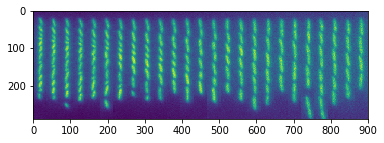

In [12]:
plt.imshow(input_kymo.return_unwrap(padding=3))
plt.show()

In [15]:
seg = fluo_segmentation("","",["channel_RFP"])

In [16]:
test_out = seg.segment(array)

/home/de64/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [20]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [21]:
%memit segment(array,threshold_range=20,threshold_step=10,convex_threshold=0.8)

peak memory: 376.14 MiB, increment: 163.60 MiB


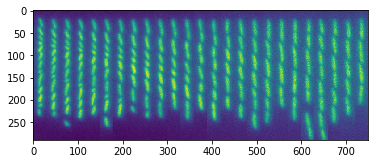

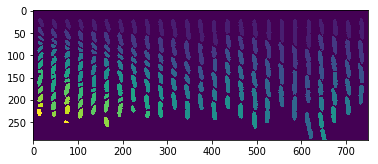

In [19]:
plt.imshow(input_kymo.return_unwrap())
plt.show()
output_kymo = tr.utils.kymo_handle()
output_kymo.import_wrap(test_out)
plt.imshow(output_kymo.return_unwrap())
plt.show()

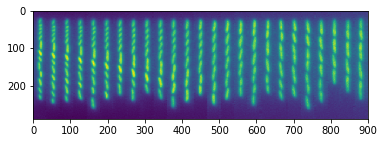

In [65]:
working_img = preprocess_img(input_kymo.return_unwrap(padding=3),sigma=0.75)
plt.imshow(working_img)
plt.show()

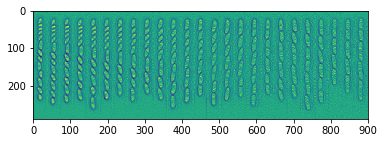

In [66]:
inverted = sk.util.invert(working_img)
min_eigvals = to_8bit(hessian_contrast_enc(inverted,4))
plt.imshow(min_eigvals)

plt.show()

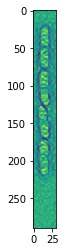

In [67]:
eig_kymo = kymo_handle()
eig_kymo.import_unwrap(min_eigvals,25,padding=3)
wrap_eig = eig_kymo.return_wrap()
plt.imshow(wrap_eig[:,:,23])
plt.show()

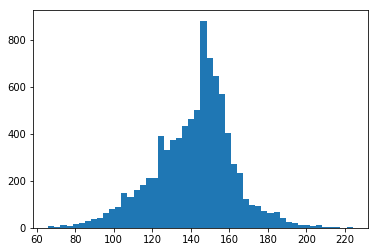

136


In [72]:
plt.hist(wrap_eig[:,:,24].flatten(),bins=50)
plt.show()

print(sk.filters.threshold_otsu(wrap_eig[:,:,24]))

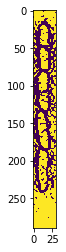

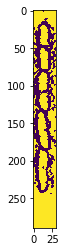

In [82]:
thr = 140
test = wrap_eig[:,:,24]>thr
plt.imshow(test)
plt.show()
for i in range(2):
    test = sk.morphology.binary_closing(test)
plt.imshow(test)
plt.show()

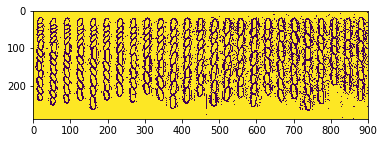

In [69]:
edge_threshold_kymo = []
for t in range(25):
    edge_threshold = sk.filters.threshold_otsu(wrap_eig[:,:,t])
    edge_thr_arr = edge_threshold*np.ones(wrap_eig[:,:,t].shape,dtype='uint8')
    edge_threshold_kymo.append(edge_thr_arr)
edge_threshold_kymo = np.array(edge_threshold_kymo)
edge_threshold_kymo = np.moveaxis(edge_threshold_kymo,(0,1,2),(2,0,1))

edge_thr_kymo = kymo_handle()
edge_thr_kymo.import_wrap(edge_threshold_kymo,scale=False)
edge_mask = min_eigvals>edge_thr_kymo.return_unwrap(padding=3)
plt.imshow(edge_mask)
plt.show()

131


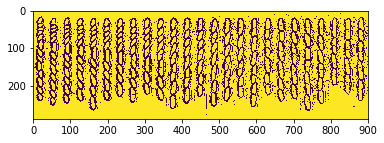

In [70]:
edge_threshold = sk.filters.threshold_otsu(min_eigvals)
print(edge_threshold)
edge_mask = min_eigvals>(edge_threshold)
plt.imshow(edge_mask)
plt.show()

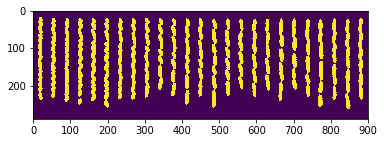

In [948]:
selem = disk(15)
local_otsu = rank.otsu(working_img, selem)
cell_local_mask = working_img>local_otsu

cell_region_threshold = sk.filters.threshold_otsu(local_otsu)
cell_region_mask = local_otsu>cell_region_threshold

cell_local_mask=cell_local_mask*cell_region_mask

plt.imshow(cell_local_mask)
plt.show()

In [857]:
composite_mask = cell_local_mask*edge_mask
composite_mask = sk.morphology.remove_small_objects(composite_mask,min_size=30)
composite_mask = sk.morphology.remove_small_holes(composite_mask)

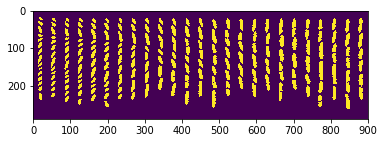

In [858]:
plt.imshow(composite_mask)
plt.show()

In [870]:
score_img = get_convex_scores(cell_local_mask,min_eigvals,edge_thr_kymo.return_unwrap(padding=3),threshold_range=20,threshold_step=10)

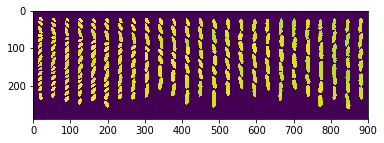

In [871]:
plt.imshow(score_img)
plt.show()

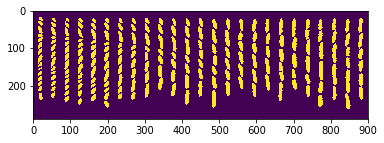

In [878]:
plt.imshow(score_img>0.8)
plt.show()

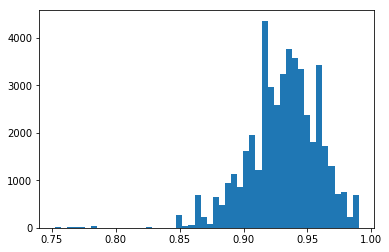

In [875]:
plt.hist(score_img[score_img>0.].flatten(),bins=50)
plt.show()

In [303]:
print(sk.filters.threshold_otsu(min_eigvals))

122


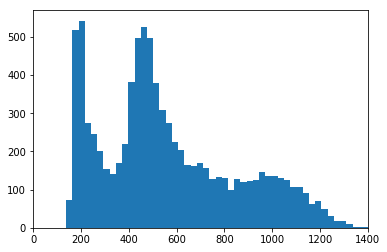

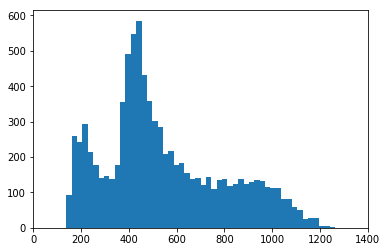

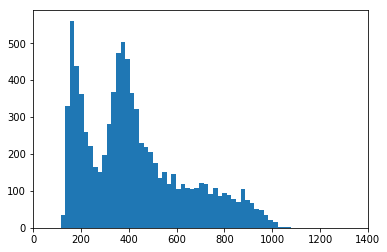

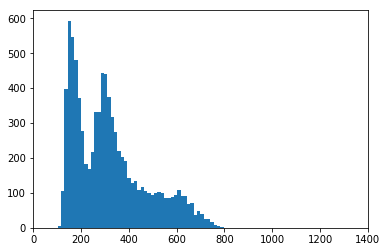

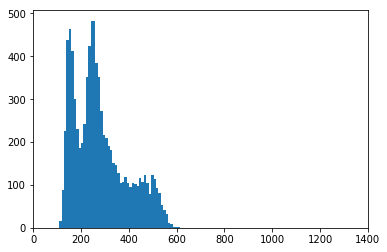

In [77]:
for t in range(0,25,5):
    plt.hist(array[:,:,t].flatten(),bins=50)
    plt.xlim(0,1400)
    plt.show()

In [55]:
def percentile_correction(array,percentile):
    perc_t = np.percentile(array[:].reshape(-1,array.shape[2]),percentile,axis=0)
    norm_perc_t = perc_t/np.max(perc_t)
    corrected_arr = array/norm_perc_t[np.newaxis,np.newaxis,:]
    return corrected_arr
def to_8bit(array)

In [56]:
corrected_arr = percentile_correction(array[:],80)

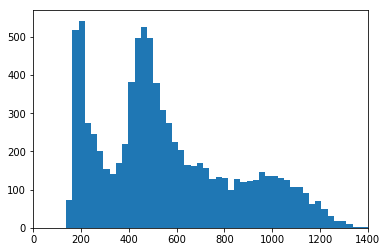

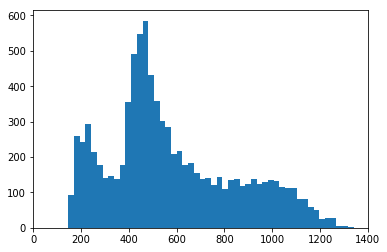

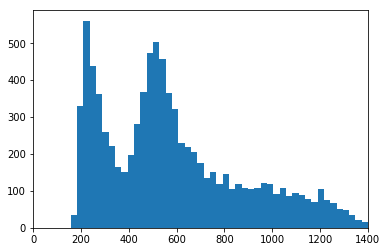

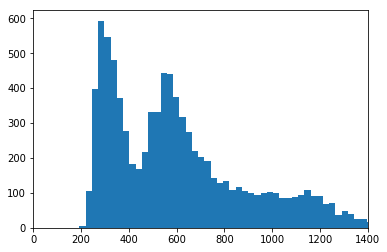

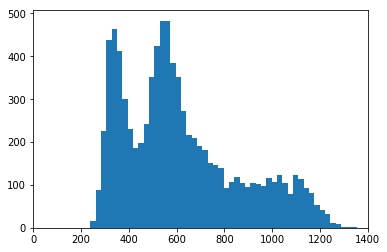

In [57]:
for t in range(0,25,5):
    plt.hist(corrected_arr[:,:,t].flatten(),bins=50)
    plt.xlim(0,1400)
    plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

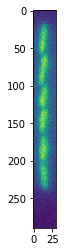

In [46]:
plt.imshow(corrected_arr[:,:,24])
plt.show

In [ ]:
def make_mask(array,sigma=0.75,otsu_scaling=1.):
    array = sk.filters.gaussian(array,sigma)
    
    otsu_th = sk.filters.threshold_otsu(array)*otsu_scaling
    array>otsu_th